# Natural Language Geneartion 
## (Word - by - Word)
Generate new Answer Cards using RNN

#### Pre-processing  
Length of vocab: 1465  
Length of first line: 5

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import silhouette_score
from sklearn import metrics

import numpy as np
import random
import pandas as pd
import os
import pickle

In [3]:
os.chdir('/Users/bellepeng/Desktop/Metis/Projects/NLP_CardsAgainstHumanity/data')

In [4]:
with open('w2v_pred_words_flat.pkl', 'rb') as picklefile:
    w2v_pred_words_flat = pickle.load(picklefile)
    
print("Length of vocab:", len(w2v_pred_words_flat)) # Length of vocab
print("Length of first line:", len(w2v_pred_words_flat[1]))

Length of vocab: 1465
Length of first line: 5


#### Model Prep

In [4]:
word_to_ix = {}
for sent in w2v_pred_words_flat:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

In [5]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

In [6]:
inputs = [prepare_sequence(sent, word_to_ix) for sent in w2v_pred_words_flat]
print(len(inputs))
inputs[0]

1465


tensor([0, 1, 2, 3, 4])

In [7]:
print(word_to_ix)

{'sleep': 0, 'night': 1, '?': 2, 'passage': 3, 'time': 4, 'turning': 5, '32': 6, 'wearing': 7, 'glasses': 8, 'sounding': 9, 'smart': 10, 'shitting': 11, 'floor': 12, 'like': 13, 'bad': 14, 'girl': 15, 'salsa': 16, 'dave': 17, "'s": 18, 'cantina': 19, '99': 20, 'problems': 21, 'one': 22, 'rival': 23, 'dojo': 24, 'web': 25, 'lies': 26, 'google': 27, 'sea': 28, 'troubles': 29, 'intimacy': 30, 'best': 31, 'friend': 32, 'medium': 33, 'horchata': 34, 'happy': 35, 'daddies': 36, 'sandals': 37, 'opening': 38, 'mouth': 39, 'talk': 40, 'big': 41, 'penis': 42, 'fops': 43, 'seeing': 44, 'things': 45, 'hitler': 46, 'perspective': 47, 'bees': 48, 'smell': 49, 'genghis': 50, 'khan': 51, 'dna': 52, 'putting': 53, 'entire': 54, 'peanut': 55, 'butter': 56, 'jelly': 57, 'sandwich': 58, 'vcr': 59, 'long': 60, 'finding': 61, 'cards': 62, 'humanity': 63, 'card': 64, 'funny': 65, 'homeless': 66, 'people': 67, 'way': 68, 'world': 69, 'ends': 70, '/': 71, 'bang': 72, 'trillion': 73, 'dollars': 74, 'sexy': 75, 

In [8]:
def return_pred_word(tensors):
    words = []
    for t in range(len(tensors)):
         words.append([key  for (key, value) in word_to_ix.items() if value == tensors[t]])
    return words

In [24]:
def output_results(model, text):
    from itertools import chain

    print(text)
    with torch.no_grad():
        inputs = prepare_sequence(text, word_to_ix)
        tag_scores = model(inputs)
    post_train_max = [s.argmax() for s in tag_scores]
    pred_words = return_pred_word(post_train_max)
    
    return ' '.join(list(chain.from_iterable(pred_words)))

#### Model

In [10]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, vocab_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(1, 1, self.hidden_dim),
                torch.zeros(1, 1, self.hidden_dim))

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, self.hidden = self.lstm(
            embeds.view(len(sentence), 1, -1), self.hidden)
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [11]:
EMBEDDING_DIM = 6
HIDDEN_DIM = 6
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [14]:
ix=0
print(w2v_pred_words_flat[ix]) 
print("# of Words:", len(w2v_pred_words_flat[ix]))  # 5 words
print("# of Inputs:", len(inputs))                  # 5 inputs
# print("len(tag_scores):", len(tag_scores))          # 5 tag scores      
print("len(word_to_ix)):", len(word_to_ix))         # 2433 vocab
# for i in range(2):                                  # 2433 tensors for each
#     print("len(tag_scores[i])):", len(tag_scores[i]))  # 2433 vocab and 2433 tensors
print()
output_results(w2v_pred_words_flat[ix])

['sleep', 'night', '?', 'passage', 'time']
# of Words: 5
# of Inputs: 1465
len(word_to_ix)): 2441

['sleep', 'night', '?', 'passage', 'time']


'hacky-sack ridicule caress ridicule union'

In [15]:
training_data = w2v_pred_words_flat
loss_agg=[]
loss_avg=0
plot_every = 30

for epoch in range(300):  # again, normally you would NOT do 300 epochs, it is toy data
    loss_avg = 0
    for sentence in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        model.hidden = model.init_hidden()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence[:-1], word_to_ix)
        targets = prepare_sequence(sentence[1:], word_to_ix)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss_avg += loss.data.item()
       
        loss.backward()
        optimizer.step()
    
    if epoch % plot_every == 0:
        print(f"Epoch {epoch} loss_avg:", loss_avg/len(training_data))
    
    loss_agg.append(loss)

Epoch 0 loss_avg: 7.538853333346266
Epoch 30 loss_avg: 5.400588258338056
Epoch 60 loss_avg: 4.787212612807954
Epoch 90 loss_avg: 4.5009589419430025
Epoch 120 loss_avg: 4.261639579855948
Epoch 150 loss_avg: 4.107708589493618
Epoch 180 loss_avg: 3.984579068035803
Epoch 210 loss_avg: 3.89648147959758
Epoch 240 loss_avg: 3.7834148359786934
Epoch 270 loss_avg: 3.719182936282695


In [16]:
output_results(training_data[0])

['sleep', 'night', '?', 'passage', 'time']


'! ! pussy < good'

In [27]:
print(output_results(model, ['sleep', 'night', '?']))
print(output_results(model, ['batman', 'guilty', 'pleasure']))
print(output_results(model, ['next', 'happy', 'meal', 'toy', '?']))

['sleep', 'night', '?']
night life bees
['batman', 'guilty', 'pleasure']
know 's love
['next', 'happy', 'meal', 'toy', '?']
office show child could bees


loss_avg: 5330.717501401901


Text(0,0.5,'Neg Log Likelihood Loss')

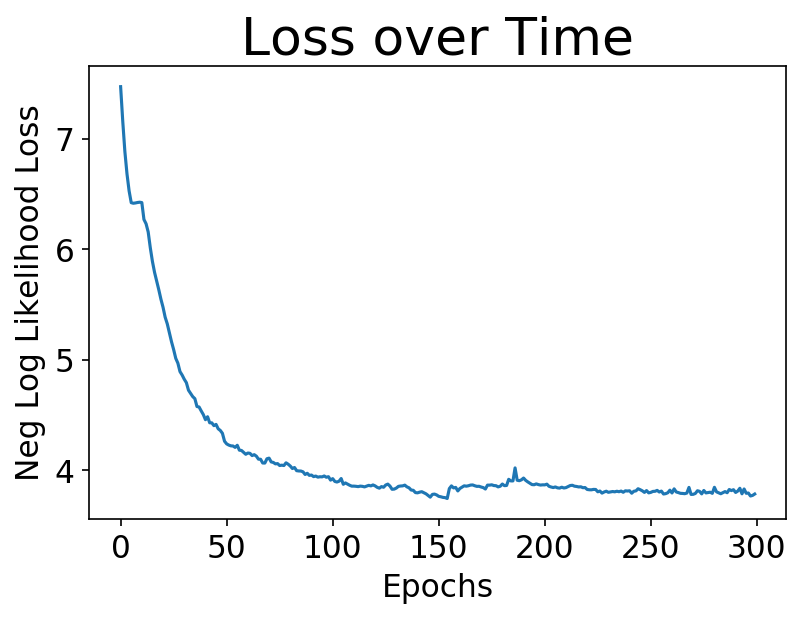

In [20]:
# print("len loss agg:", len(loss_list))
print("loss_avg:", loss_avg)
plt.figure(dpi=150)
plt.plot(range(len(loss_agg)), loss_agg)
plt.title('Loss over Time', size=25)
plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Neg Log Likelihood Loss', fontsize=15)

In [5]:
import os
os.chdir('/Users/bellepeng/Desktop/Metis/Projects/NLP_CardsAgainstHumanity/data')
torch.save(model, 'model_nlg_1.pt')

In [25]:
model_nlg1_v2 = torch.load('model_nlg_1.pt')

In [26]:
print(output_results(model_nlg1_v2, ['next', 'happy', 'meal', 'toy', '?']))

['next', 'happy', 'meal', 'toy', '?']
universe firm yet giving bees
